In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
from pytz import timezone

import sys

sys.path.append("../../../")

from utils.plot import (
    config_matplotlib,
    figsize,
    fig_save_and_show,
    plot_events_data,
)
from utils.optimization import (
    save_model_params_to_json,
    load_model_params_from_json,
)
from utils.data import (
    export_dataframe_to_latex,
)
from utils.sensitivity_analysis import (
    describe_param_with_uniform_distribution,
    describe_param_with_log_uniform_distribution,
    describe_param_with_triangular_distribution,
    describe_param_with_normal_distribution,
    describe_param_with_truncated_normal_distribution,
    describe_param_with_log_normal_distribution,
    wrapped_model_function,
    create_problem_spec_and_sample,
    plot_sampled_distribuitions,
    evaluate_problem,
    analyze_time_step,
    analyze_problem,
    sobol_sensitivity_analysis_from_model_params_to_outputs,
    plot_sensitivity_analysis,
    plot_sensitivity_analysis_heatmaps,
    get_region_mean,
    plot_sensitivity_analysis_bars,
)
from utils.models import eval_poly, lut_interp

import warnings

warnings.filterwarnings("ignore")

config_matplotlib()
latex_img_path = "/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/"
latex_tex_path = "/home/joaoantoniocardoso/workspace_TCC/repo/tcc/tex/"

# Sensitivity Analysis


In [2]:
from model import Battery as Battery

Battery.build({})

<NonlinearIOSystem battery: ['batt_i'] -> ['batt_v', 'batt_z', 'batt_ocv']>

In [3]:
batt_name = "D35"
cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 1.1
nominal_voltage = series_cells * cell_voltage
ocv_params = load_model_params_from_json("battery_ocv_params.json")
batt_k_V_OC_coeffs = ocv_params["batt_k_V_OC_coeffs"]
# batt_ocv_lut = ocv_params['batt_ocv_lut']

battery_params = {
    "batt_N_S": series_cells,
    "batt_Q": cell_amps_hour * 3600,
    "batt_eta": 1,
    "batt_R_0": 3e-3,
    "batt_R_1": 10e-2,
    "batt_C_1": 5e3,
    "batt_R_2": 10e-2,
    "batt_C_2": 5e6,
    "batt_k_V_OC_coeffs": batt_k_V_OC_coeffs,
}

model_params = battery_params
model_params

{'batt_N_S': 3,
 'batt_Q': 172800,
 'batt_eta': 1,
 'batt_R_0': 0.003,
 'batt_R_1': 0.1,
 'batt_C_1': 5000.0,
 'batt_R_2': 0.1,
 'batt_C_2': 5000000.0,
 'batt_k_V_OC_coeffs': array([10.78645833,  3.58638935, -3.07530114,  1.61637218])}

In [4]:
def _estimate_open_circuit_voltage(params, batt_z):
    if "batt_ocv_lut" in params:
        return float(lut_interp(params["batt_ocv_lut"], batt_z))
    if "batt_k_V_OC_coeffs" in params:
        coeffs = params["batt_k_V_OC_coeffs"]
        try:
            return float(lut_interp(coeffs, batt_z))
        except Exception:
            return float(eval_poly(coeffs, batt_z))
    return 0.0


def model_function(T, U, X0, **params):
    return ct.input_output_response(
        Battery.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method="Radau",
    ).to_pandas()


def battery_sensitivity_analysis_step_response(
    params_description: dict,
    current_step: float,
    samples: int,
    do_plot=True,
):
    model_class = Battery
    model_tmp = model_class.build(model_params)

    T = np.linspace(0, 200, 201, endpoint=True)

    U = np.empty([model_tmp.ninputs, len(T)]) * np.nan
    U[model_tmp.input_labels.index("batt_i")] = current_step

    batt_z_0 = 0.9
    batt_v_0 = model_params.get("batt_N_S", 1) * _estimate_open_circuit_voltage(
        model_params, batt_z_0
    )

    X0 = model_class.initial_state(
        X0={
            "batt_z": batt_z_0,
            "batt_v": batt_v_0,
        },
        U0=U[:, 0],
        params=model_params,
    )

    df_sa, problem = sobol_sensitivity_analysis_from_model_params_to_outputs(
        params_description=params_description,
        T=T,
        U=U,
        X0=X0,
        model_function=model_function,
        model_class=model_class,
        model_params=model_params,
        samples=samples,
        calc_second_order=False,
        seed=42,
        nprocs=32,
    )

    df_steady_state_mean = get_region_mean(df_sa, t_start=180, t_end=200)

    export_dataframe_to_latex(
        filename=f"{latex_tex_path}/PNGV_2rc_sensitivity_analysis_{current_step}.tex",
        label=f"table:PNGV_2rc_sensitivity_analysis_{current_step}",
        caption="Índices de Sobol em regime permanente",
        df_steady_state_mean=df_steady_state_mean,
    )

    if do_plot:
        display(df_steady_state_mean)

        fig_save_and_show(
            filename=f"{latex_img_path}/PNGV_2rc_sensitivity_analysis_distributions.pdf",
            save_title="Distribuição dos valores para cada fator",
            show_title="Distribution of the values for each factor",
            fig=plot_sampled_distribuitions(problem),
            ncols=3,
        )

        for output in df_sa["output"].unique():
            fig_save_and_show(
                filename=f"{latex_img_path}/PNGV_2rc_sensitivity_analysis_{current_step}_{output}.pdf",
                save_title=f"Índices de Sobol para a saída {output} durante o tempo, com degrau de {current_step} [A], com {samples} amostras",
                show_title=f"Sobol Indices for the output {output} over time with step of {current_step} [A], with {samples} samples",
                fig=plot_sensitivity_analysis(df_sa, output=output),
                ncols=3,
            )

        for output in df_sa["output"].unique():
            fig_save_and_show(
                filename=f"{latex_img_path}/PNGV_2rc_sensitivity_analysis_heatmaps_{current_step}_{output}.pdf",
                save_title=f"Índices de Sobol para a saída {output} durante o tempo, com degrau de {current_step} [A], com {samples} amostras",
                show_title=f"Sobol Indices for the output {output} over time with step of {current_step} [A], with {samples} samples",
                fig=plot_sensitivity_analysis_heatmaps(df_sa, output=output),
                ncols=3,
            )

        for output in df_sa["output"].unique():
            fig_save_and_show(
                filename=f"{latex_img_path}/PNGV_2rc_sensitivity_analysis_bars_{current_step}_{output}.pdf",
                save_title=f"Índices de Sobol para a saída {output} em regime permanente, com degrau de {current_step} [A], com {samples} amostras",
                show_title=f"Sobol Indices for the output {output} at steady-state with step of {current_step} [A], with {samples} samples",
                fig=plot_sensitivity_analysis_bars(df_steady_state_mean, output=output),
                ncols=3,
            )

    return df_sa, problem

In [5]:
# Setting all uncertainties to be x%
u_batt_R_0 = 1 / 100
u_batt_R_1 = 1 / 100
u_batt_R_2 = 1 / 100
u_batt_C_1 = 1 / 100
u_batt_C_2 = 1 / 100
u_batt_Q = 1 / 100
u_batt_eta = 1 / 100

pool
chain


value          conf
output   factor   metric                            
batt_ocv batt_eta S1      4.915292e-01  1.011526e-01
                  ST      4.966837e-01  8.138525e-02
         batt_R_2 S1     -2.220259e-15  2.743071e-14
                  ST      2.483477e-26  1.063778e-26
         batt_R_1 S1      2.661577e-15  2.640383e-14
                  ST      2.562811e-26  1.057025e-26
         batt_R_0 S1      0.000000e+00  0.000000e+00
                  ST      0.000000e+00  0.000000e+00
         batt_Q   S1      5.031213e-01  1.239627e-01
                  ST      4.974870e-01  8.062149e-02
         batt_C_2 S1     -3.684062e-15  3.016546e-14
                  ST      2.604173e-26  1.043720e-26
         batt_C_1 S1     -2.903057e-15  2.530048e-14
                  ST      2.478811e-26  1.056853e-26
batt_v   batt_eta S1      6.751933e-03  1.414769e-02
                  ST      6.645943e-03  1.232572e-03
         batt_R_2 S1      2.869380e-07  1.122015e-04
                  ST      4.484745e-07  7.685970e-08
         batt_R_1 S1      4.995265e-01  1.013255e-01
                  ST      4.998300e-01  7.654988e-02
         batt_R_0 S1      1.750932e-02  2.297834e-02
                  ST      1.748126e-02  2.551662e-03
         batt_Q   S1      6.716490e-03  1.480347e-02
                  ST      6.656692e-03  1.143072e-03
         batt_C_2 S1      1.095041e-06  1.622549e-04
                  ST      1.002023e-06  1.550844e-07
         batt_C_1 S1      4.693573e-01  1.235045e-01
                  ST      4.690132e-01  7.712101e-02
batt_z   batt_eta S1      4.915233e-01  1.011334e-01
                  ST      4.966820e-01  8.138800e-02
         batt_R_2 S1     -3.279199e-15  9.277743e-15
                  ST      3.224548e-27  6.268473e-28
         batt_R_1 S1      3.490388e-15  9.987159e-15
                  ST      3.300449e-27  6.004442e-28
         batt_R_0 S1      0.000000e+00  0.000000e+00
                  ST      0.000000e+00  0.000000e+00
         batt_Q   S1      5.031212e-01  1.239850e-01
                  ST      4.974894e-01  8.061092e-02
         batt_C_2 S1     -2.749384e-15  1.095569e-14
                  ST      3.319448e-27  6.139964e-28
         batt_C_1 S1     -7.106620e-16  9.977296e-15
                  ST      3.443416e-27  7.042150e-28

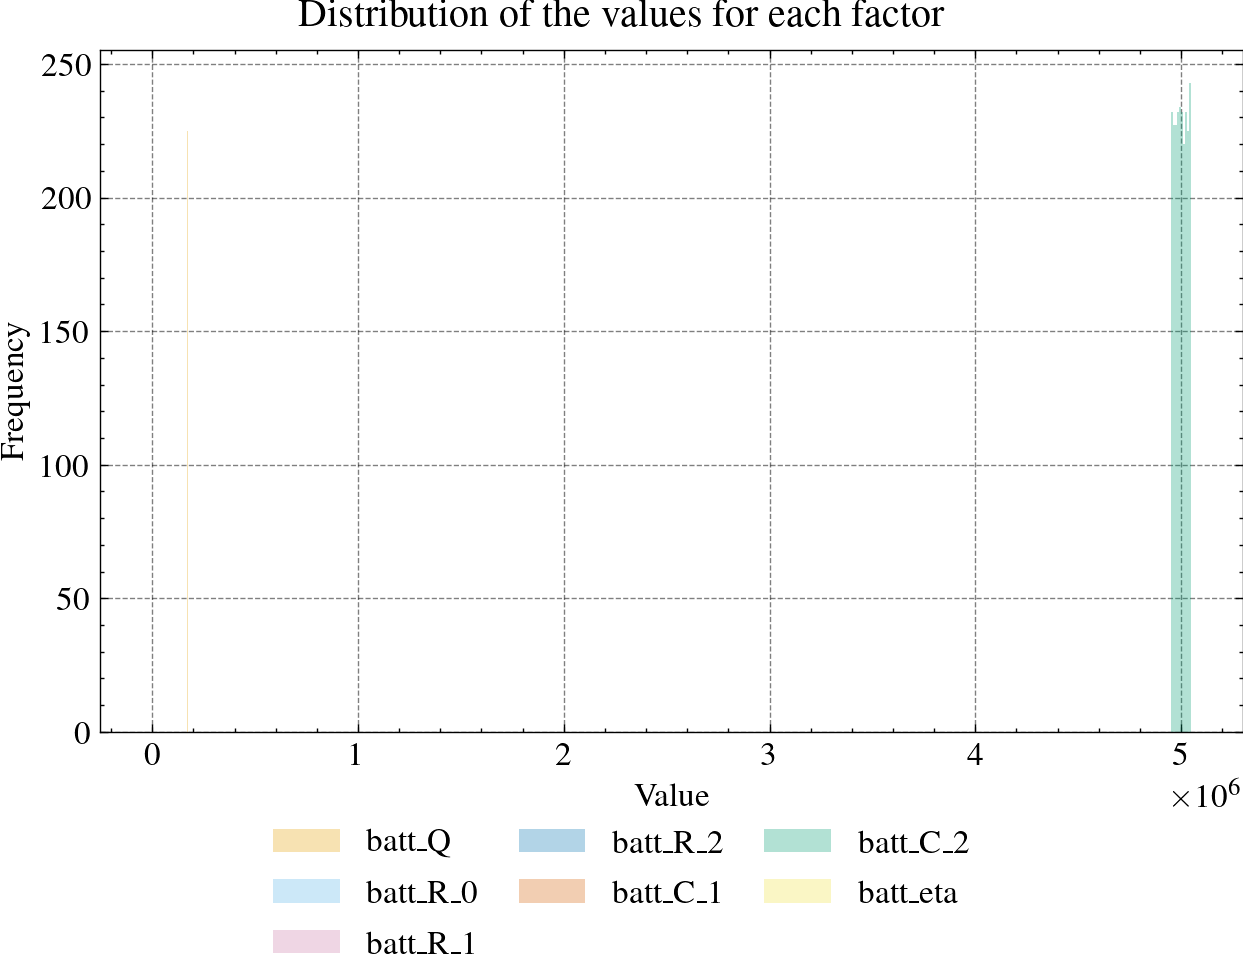

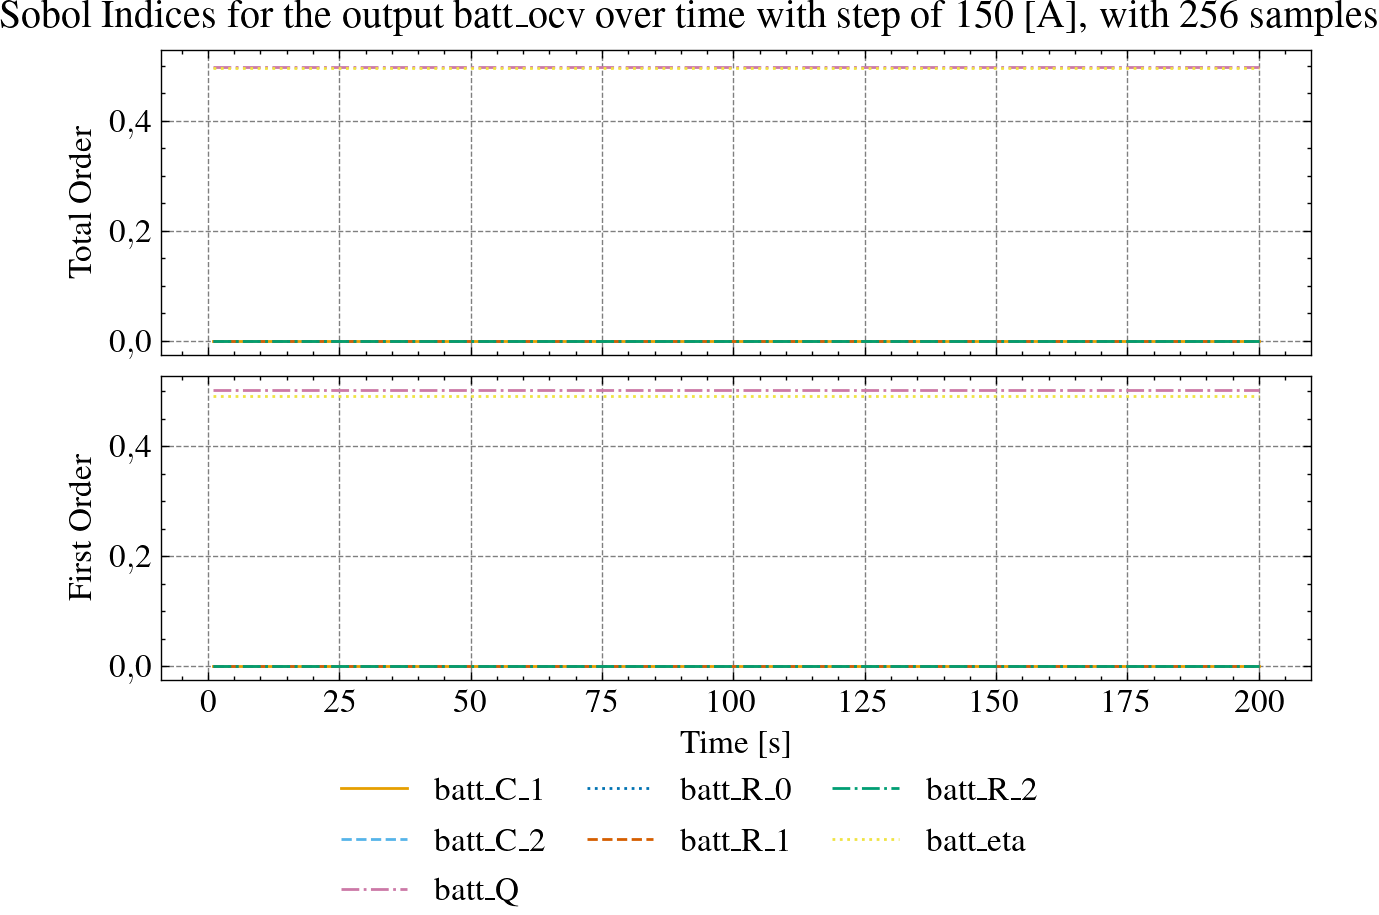

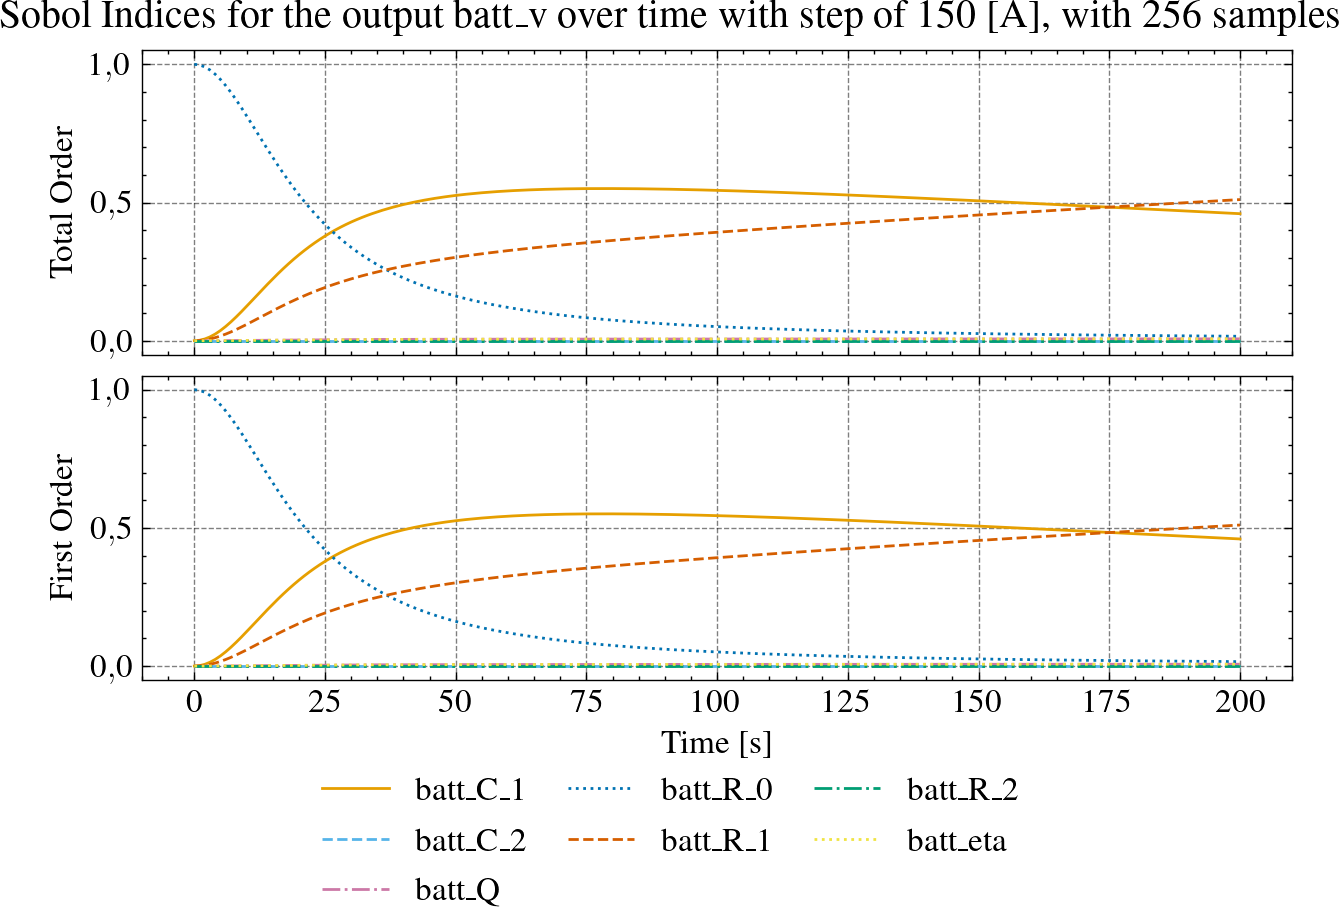

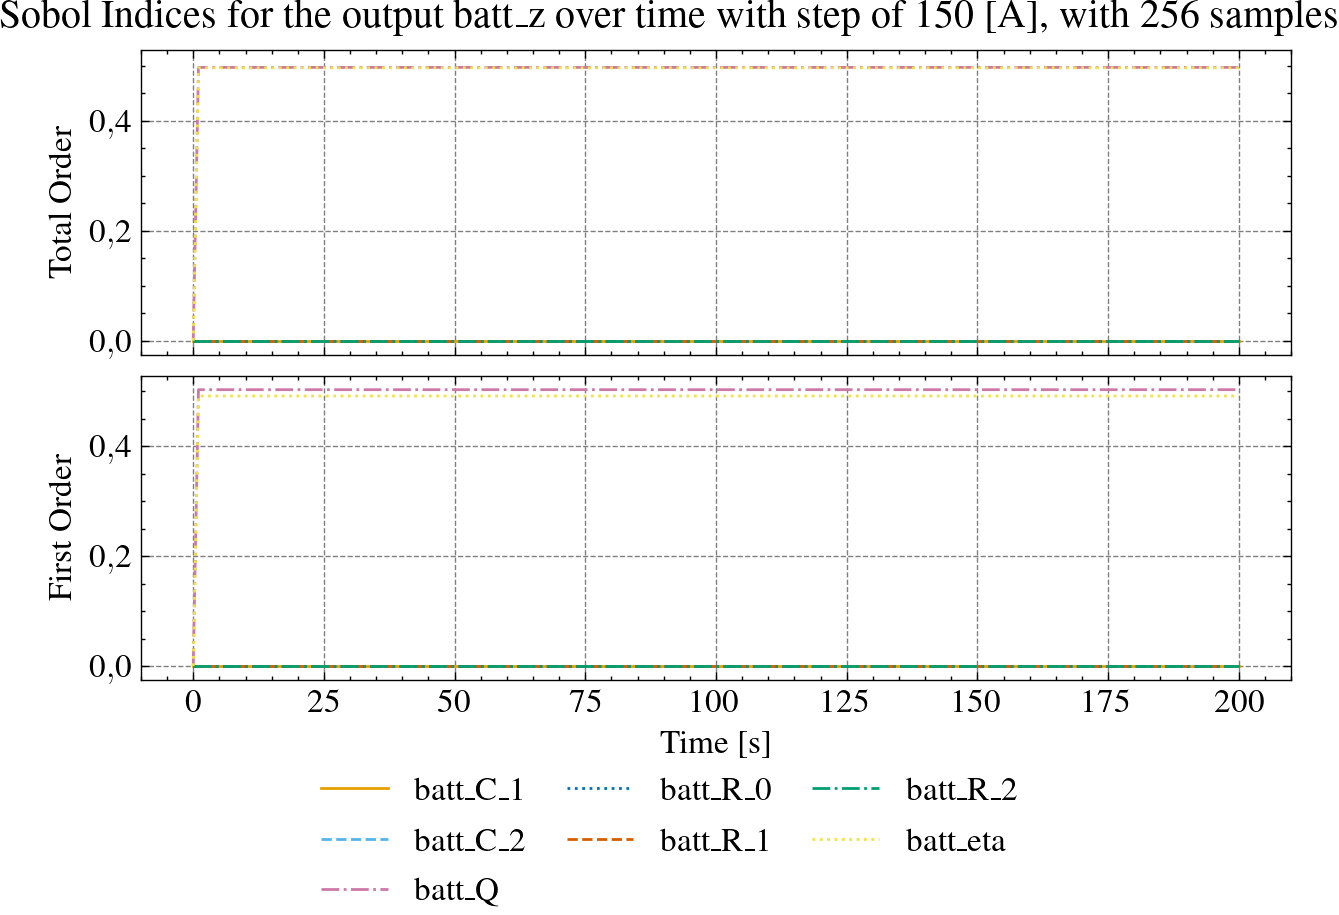

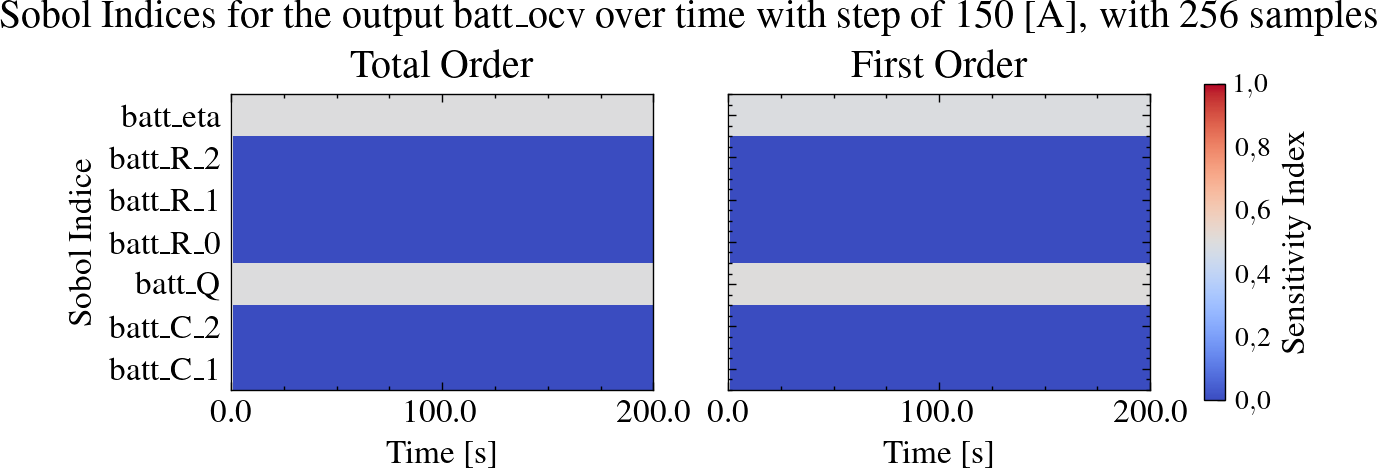

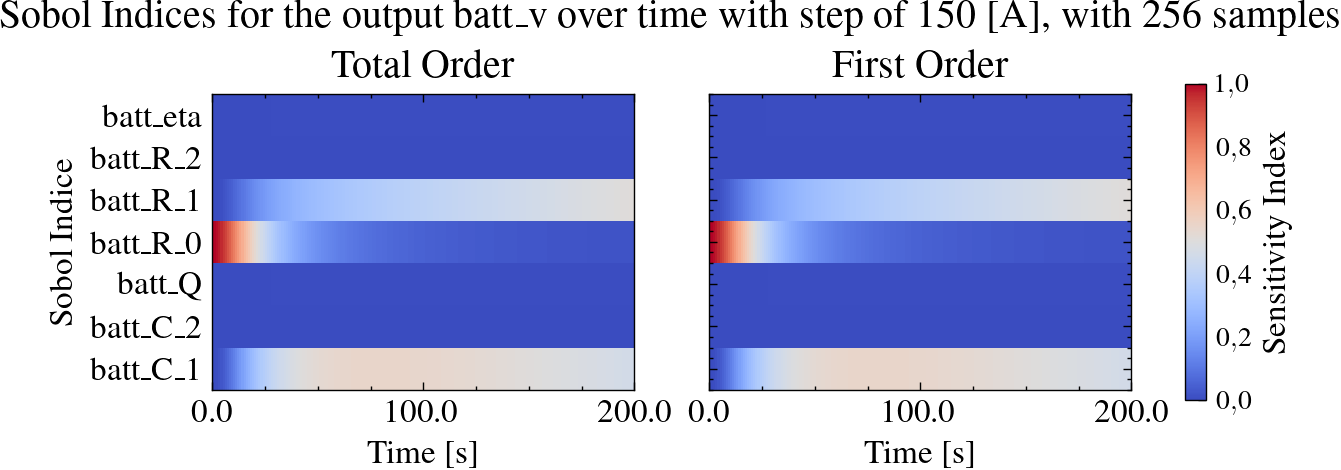

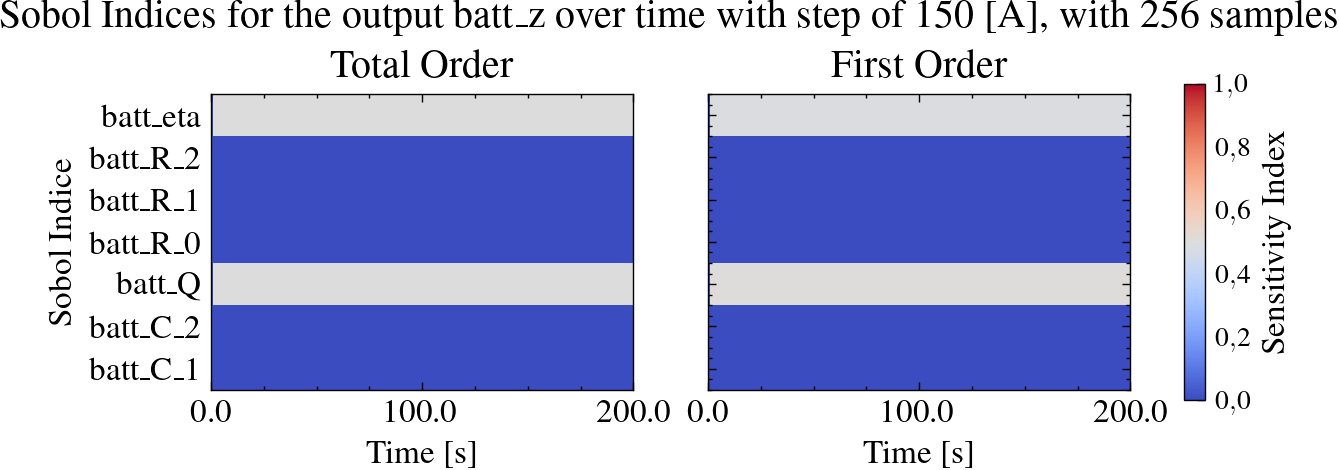

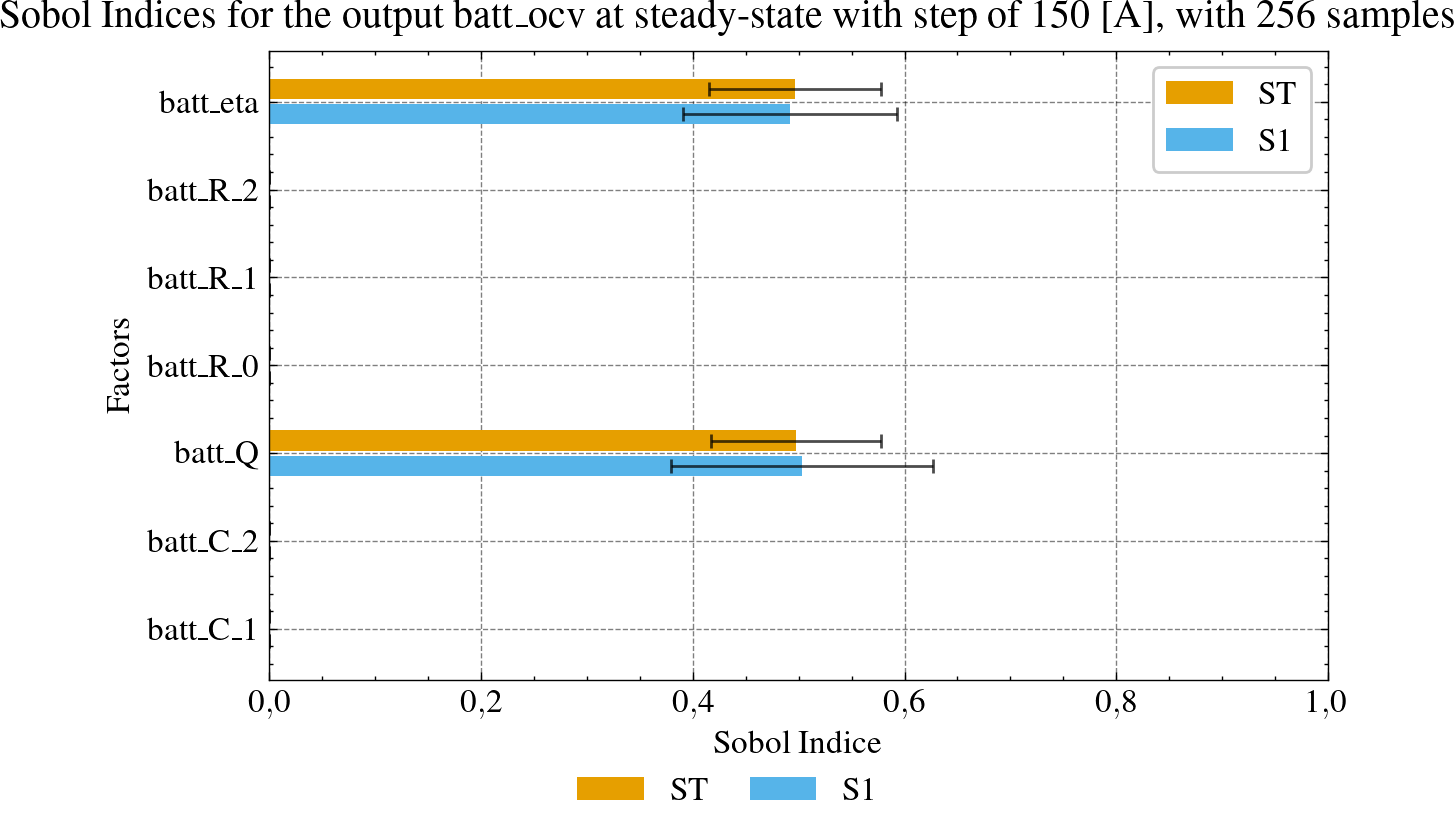

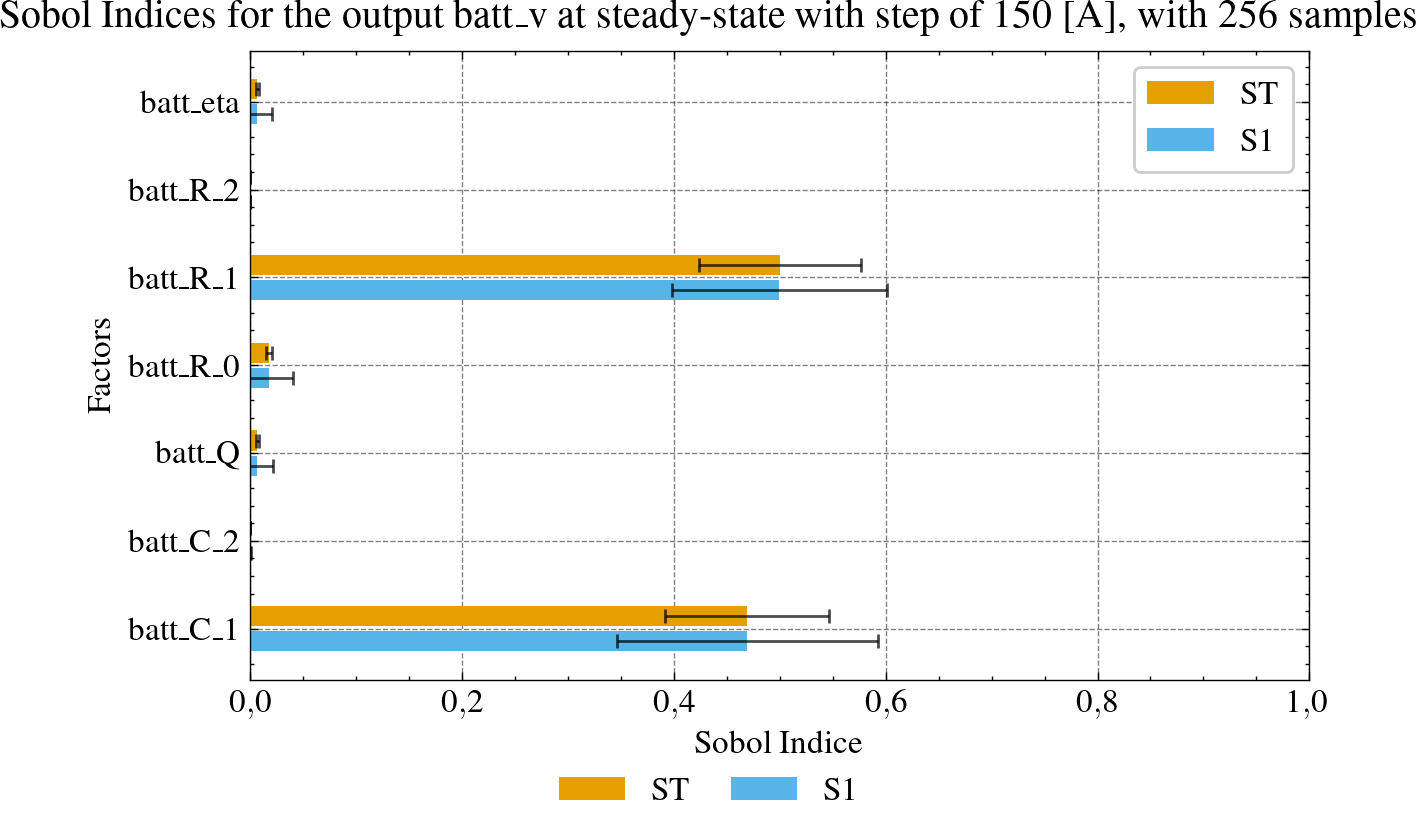

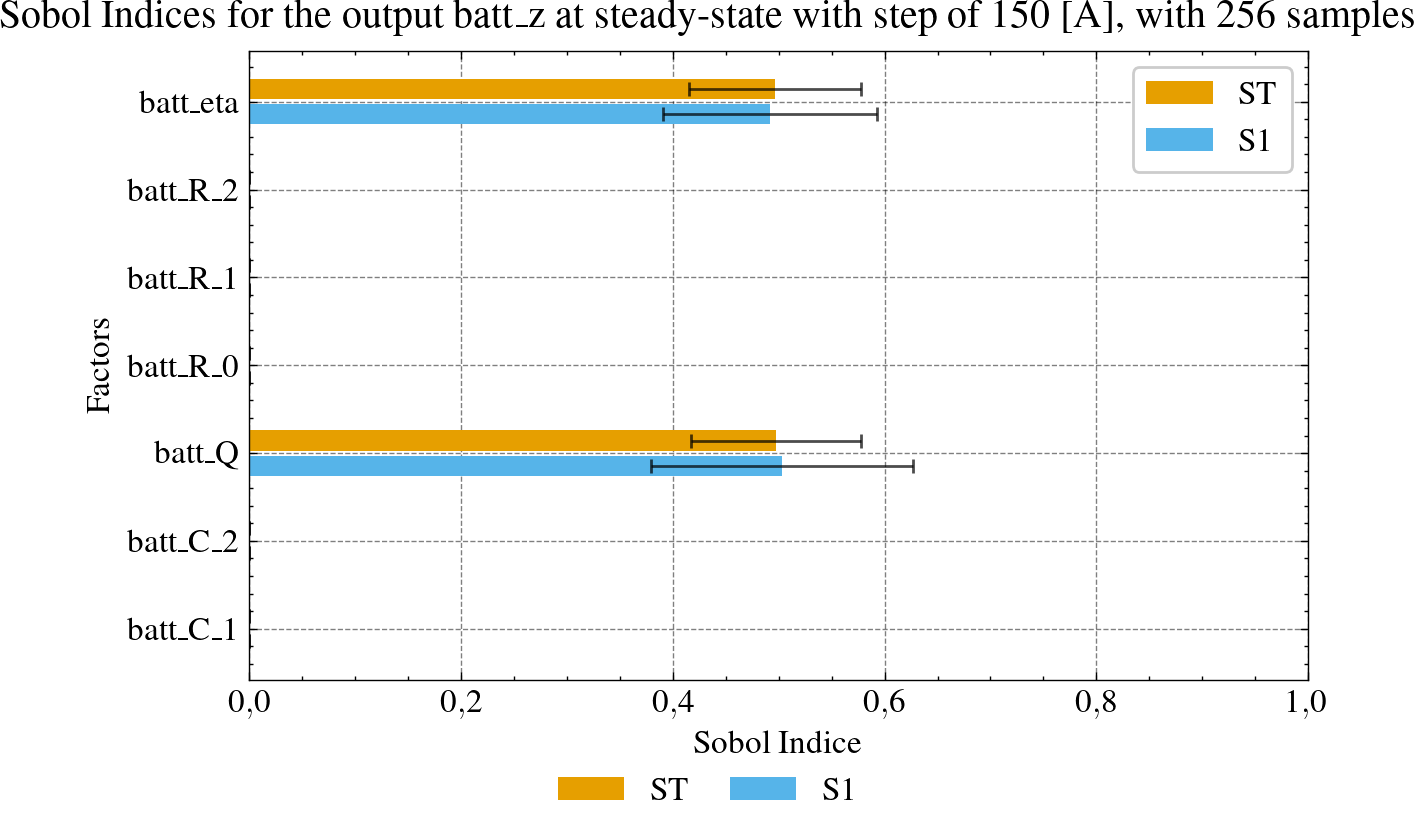

pool
chain


value          conf
output   factor   metric                            
batt_ocv batt_eta S1      4.915204e-01  1.011241e-01
                  ST      4.966811e-01  8.138944e-02
         batt_R_2 S1      2.424240e-14  1.097865e-13
                  ST      3.964773e-25  1.710165e-25
         batt_R_1 S1      3.052585e-14  1.031671e-13
                  ST      4.003461e-25  1.731498e-25
         batt_R_0 S1      0.000000e+00  0.000000e+00
                  ST      0.000000e+00  0.000000e+00
         batt_Q   S1      5.031212e-01  1.239958e-01
                  ST      4.974904e-01  8.060579e-02
         batt_C_2 S1      1.771843e-14  1.098006e-13
                  ST      4.074107e-25  1.736012e-25
         batt_C_1 S1      3.220341e-14  1.069914e-13
                  ST      4.005350e-25  1.747907e-25
batt_v   batt_eta S1      5.548645e-04  4.484546e-03
                  ST      5.817831e-04  9.637016e-05
         batt_R_2 S1      7.839859e-07  1.238855e-04
                  ST      7.102131e-07  1.189236e-07
         batt_R_1 S1      2.687425e-01  9.465686e-02
                  ST      2.687917e-01  3.910046e-02
         batt_R_0 S1      1.017042e-03  4.663173e-03
                  ST      1.014548e-03  1.690506e-04
         batt_Q   S1      5.929954e-04  4.294150e-03
                  ST      5.827311e-04  9.533082e-05
         batt_C_2 S1      1.477006e-06  2.336202e-04
                  ST      1.558444e-06  2.606850e-07
         batt_C_1 S1      7.292513e-01  1.277769e-01
                  ST      7.292005e-01  1.177807e-01
batt_z   batt_eta S1      4.915233e-01  1.011334e-01
                  ST      4.966820e-01  8.138800e-02
         batt_R_2 S1      3.070675e-15  3.894643e-14
                  ST      5.492491e-26  1.005018e-26
         batt_R_1 S1      1.398678e-14  4.126431e-14
                  ST      5.300391e-26  1.064912e-26
         batt_R_0 S1      0.000000e+00  0.000000e+00
                  ST      0.000000e+00  0.000000e+00
         batt_Q   S1      5.031212e-01  1.239850e-01
                  ST      4.974894e-01  8.061092e-02
         batt_C_2 S1     -4.707437e-15  4.467366e-14
                  ST      5.445804e-26  1.062006e-26
         batt_C_1 S1      1.784492e-14  3.882241e-14
                  ST      5.514140e-26  1.151375e-26

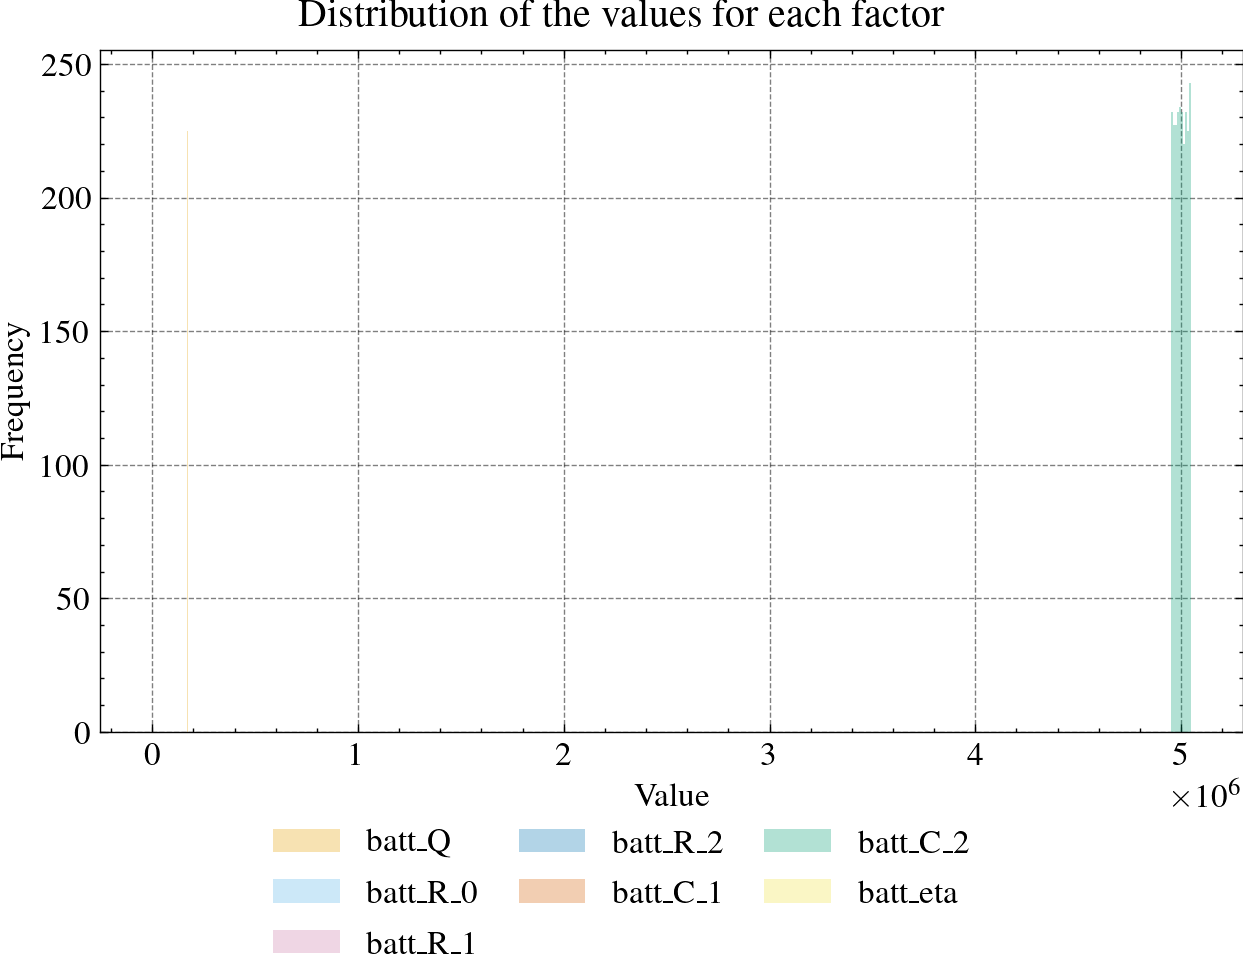

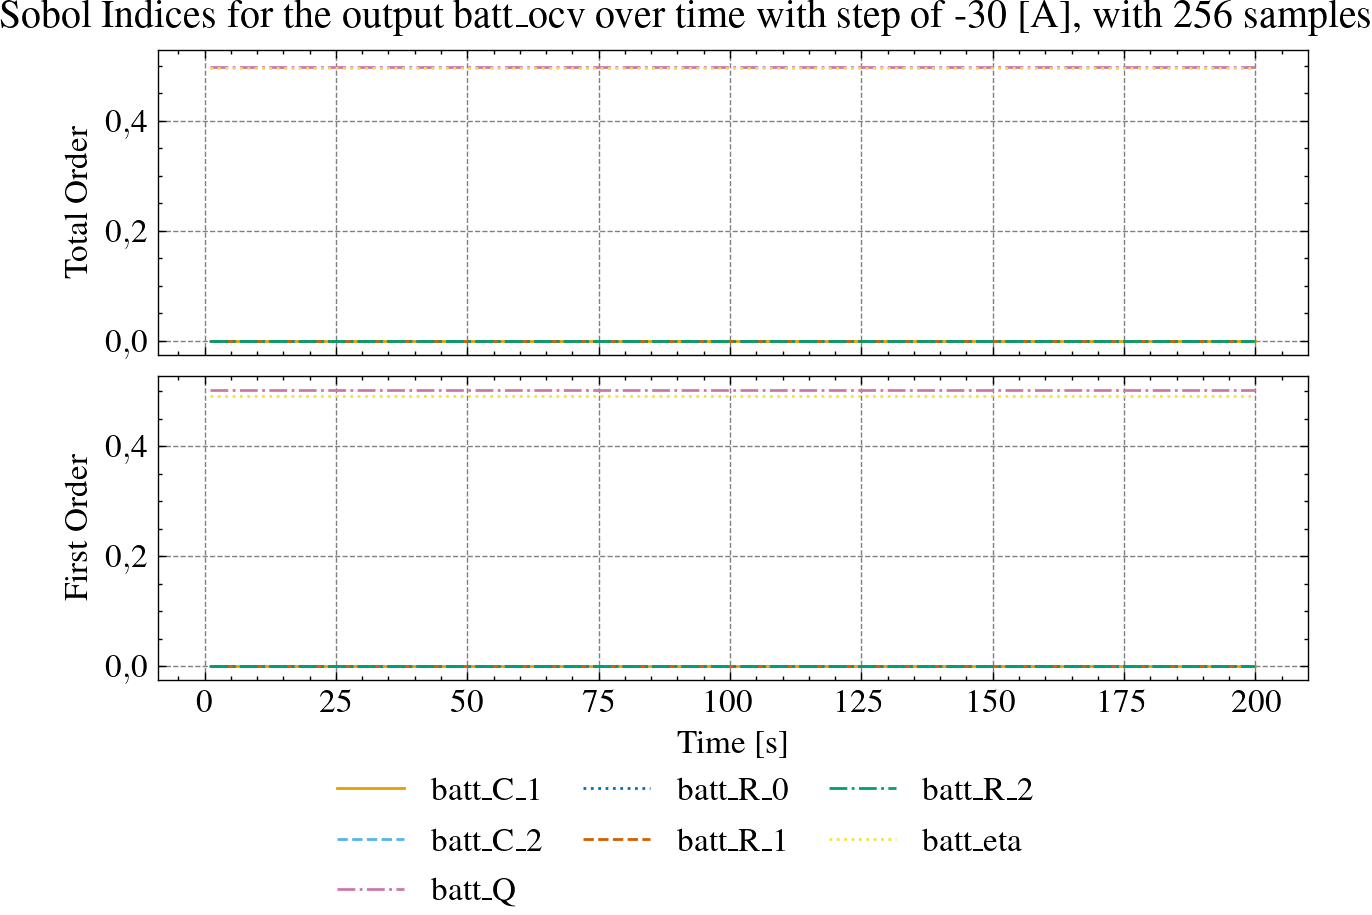

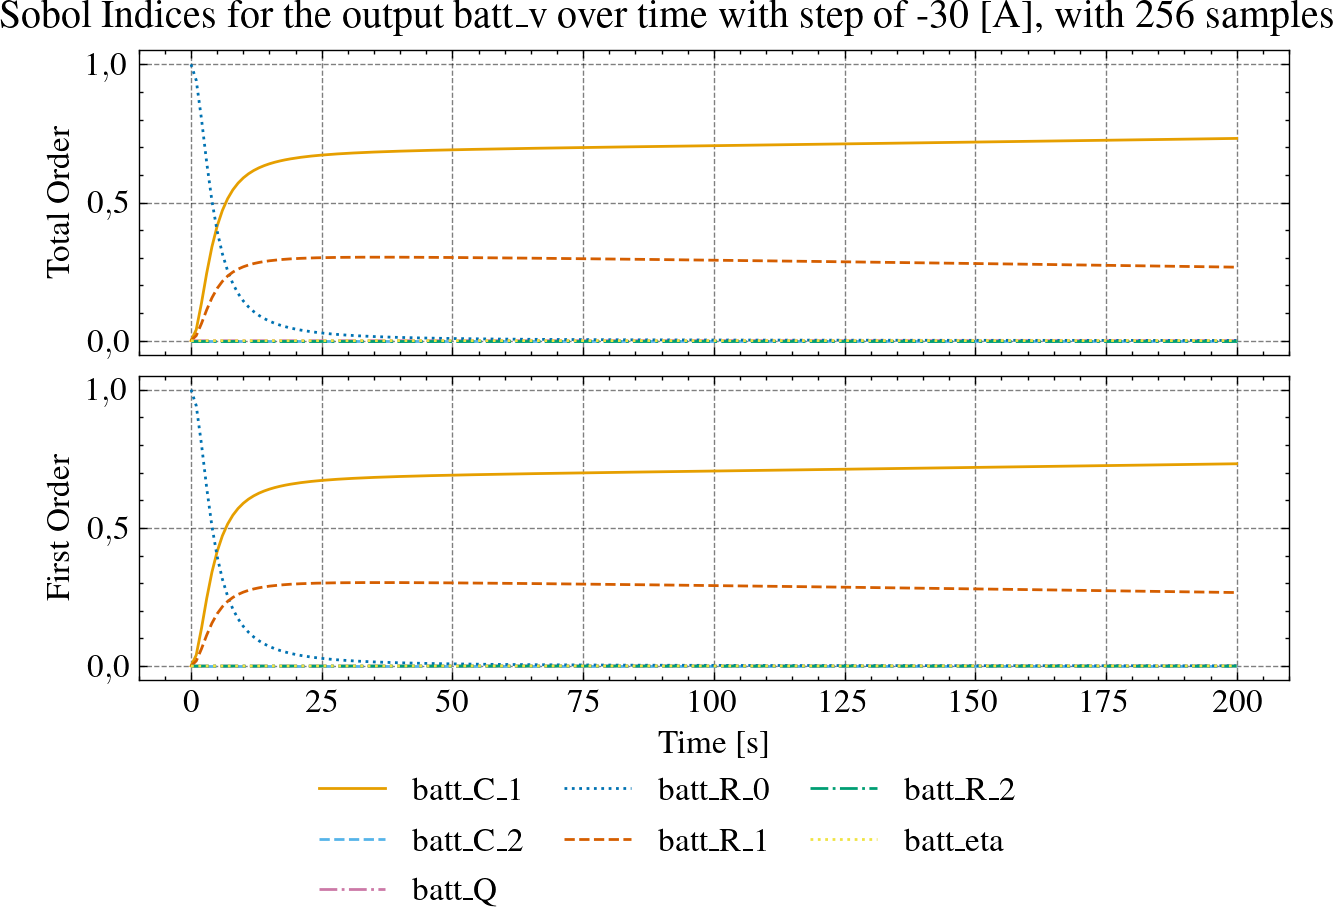

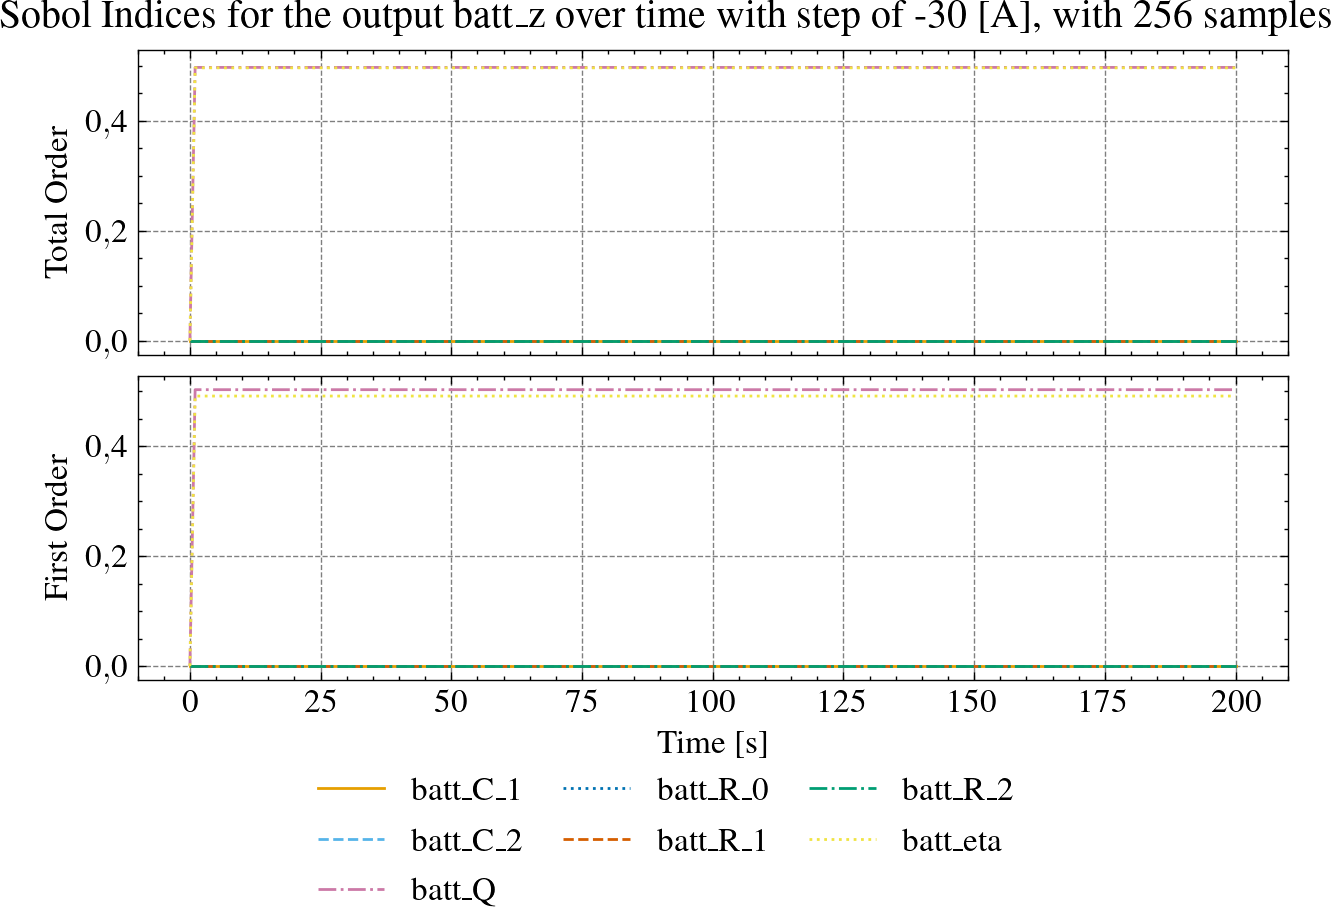

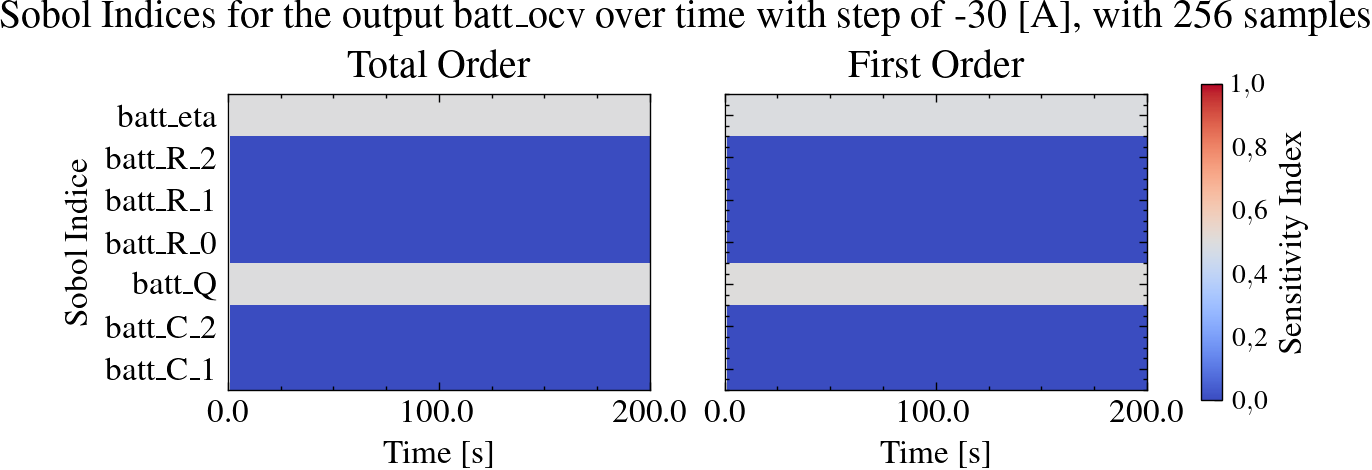

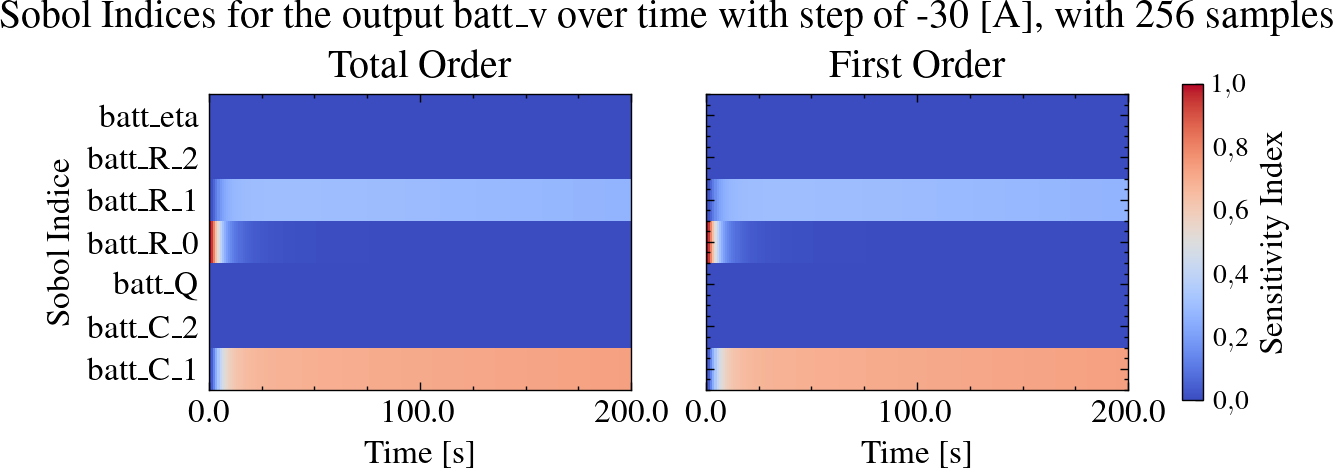

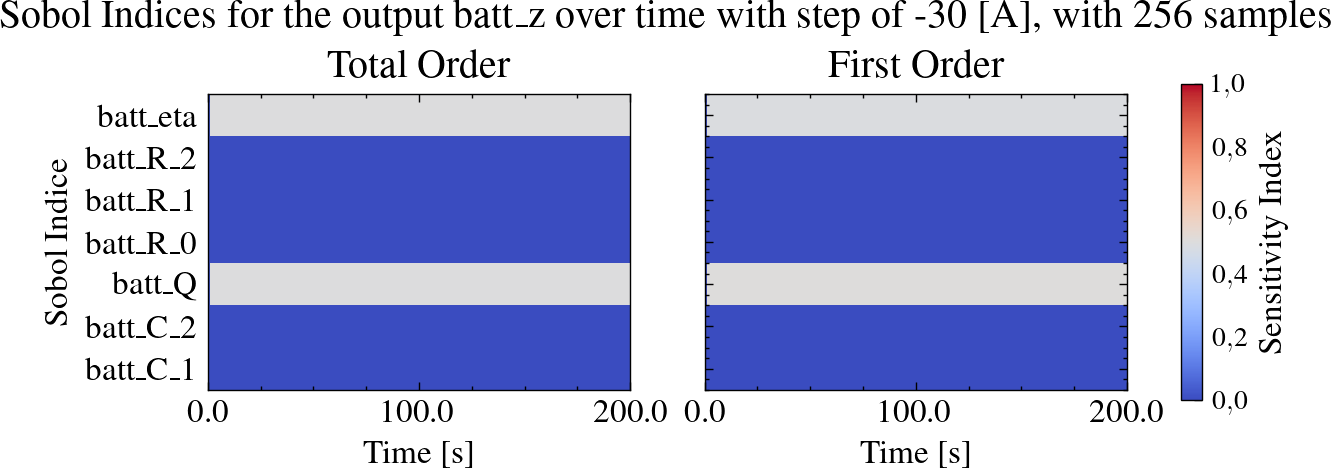

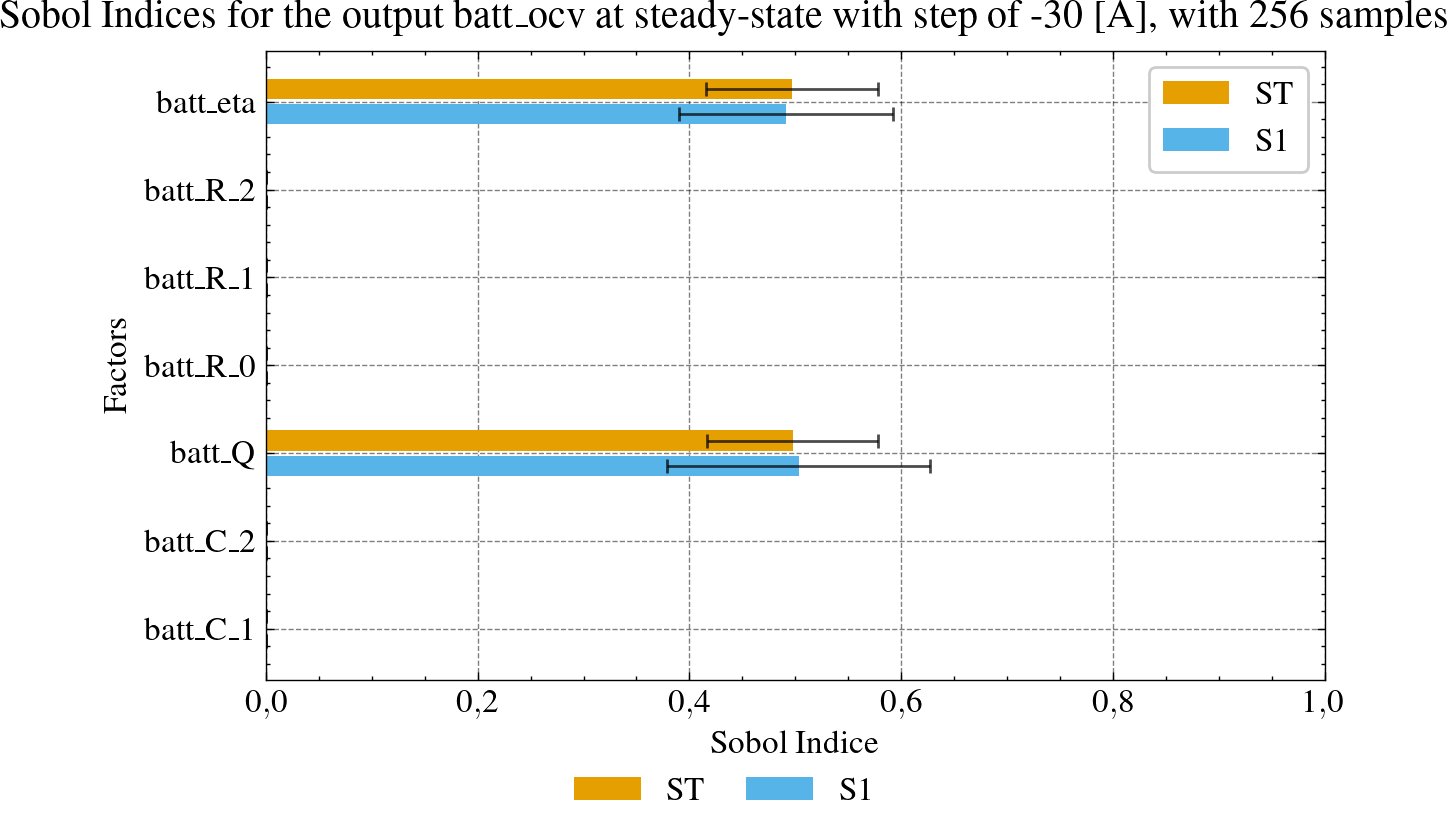

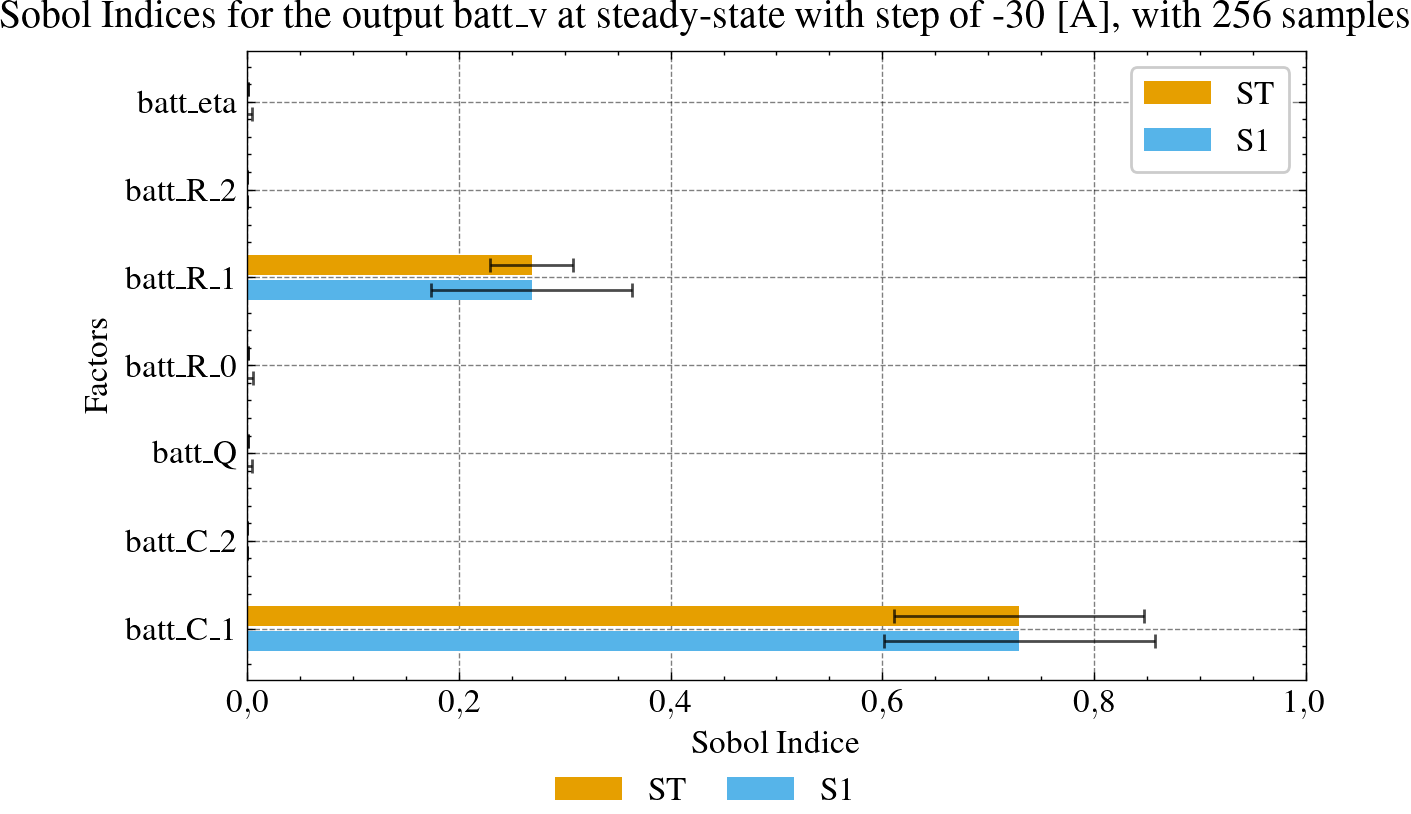

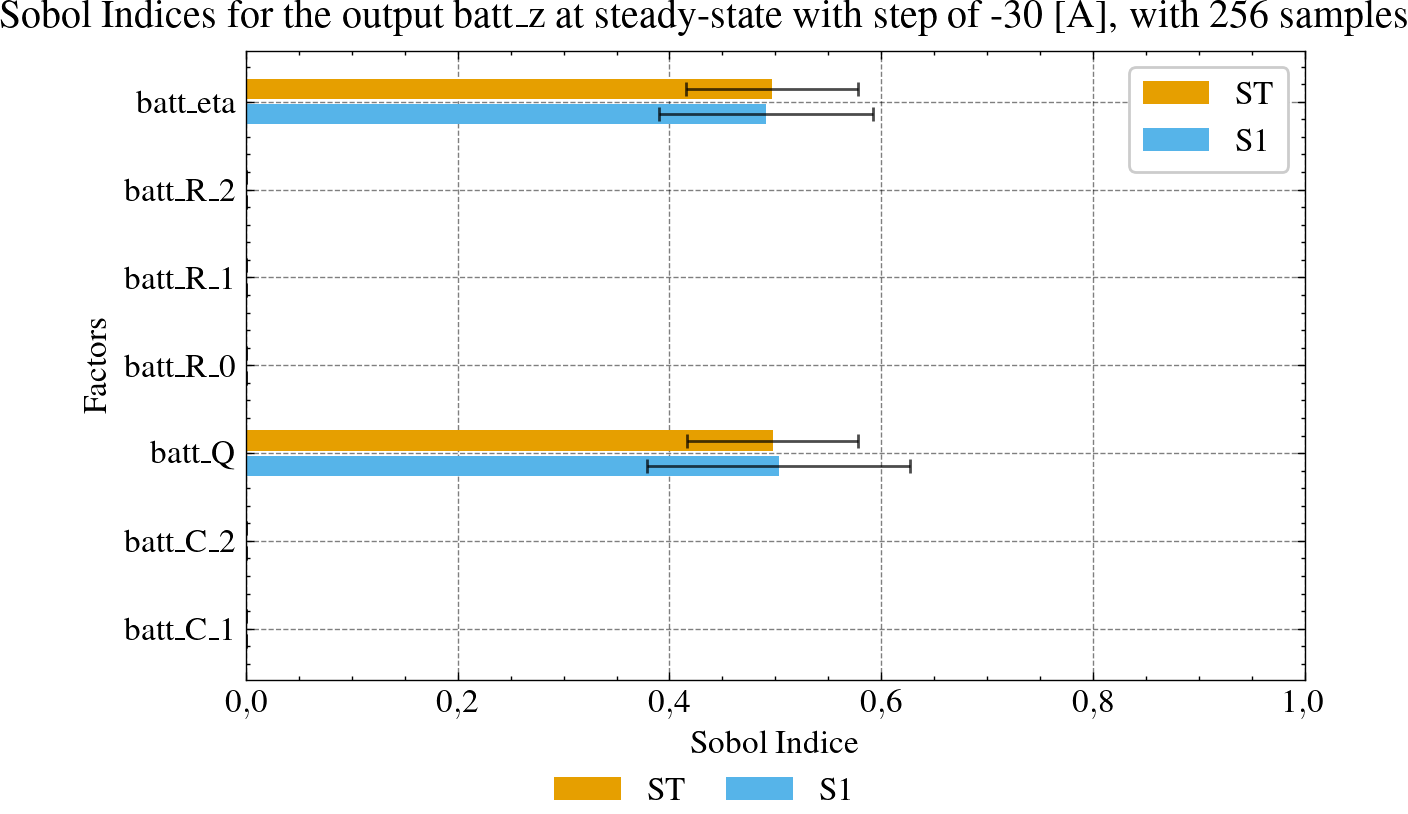

CPU times: user 16.8 s, sys: 13.8 s, total: 30.7 s
Wall time: 27.6 s


In [7]:
%%time

params_description = {
    'batt_Q': describe_param_with_uniform_distribution(lower=model_params['batt_Q']*(1-u_batt_Q), upper=model_params['batt_Q']*(1+u_batt_Q)),
    'batt_R_0': describe_param_with_uniform_distribution(lower=model_params['batt_R_0']*(1-u_batt_R_0), upper=model_params['batt_R_0']*(1+u_batt_R_0)),
    'batt_R_1': describe_param_with_uniform_distribution(lower=model_params['batt_R_1']*(1-u_batt_R_1), upper=model_params['batt_R_1']*(1+u_batt_R_1)),
    'batt_R_2': describe_param_with_uniform_distribution(lower=model_params['batt_R_2']*(1-u_batt_R_2), upper=model_params['batt_R_2']*(1+u_batt_R_2)),
    'batt_C_1': describe_param_with_uniform_distribution(lower=model_params['batt_C_1']*(1-u_batt_C_1), upper=model_params['batt_C_1']*(1+u_batt_C_1)),
    'batt_C_2': describe_param_with_uniform_distribution(lower=model_params['batt_C_2']*(1-u_batt_C_2), upper=model_params['batt_C_2']*(1+u_batt_C_2)),
    'batt_eta': describe_param_with_uniform_distribution(lower=model_params['batt_eta']*(1-u_batt_eta), upper=model_params['batt_eta']*(1+u_batt_eta)),
}

df_sa, problem = battery_sensitivity_analysis_step_response(
    params_description=params_description,
    current_step=150,
    samples=2**8,
    do_plot=True,
)


df_sa, problem = battery_sensitivity_analysis_step_response(
    params_description=params_description,
    current_step=-30,
    samples=2**8,
    do_plot=True,
)


